# Introduction
Using Python to determine an optimal portfolio using nobel prize winning Modern Portfolio Theory concepts. Checkout the [medium](https://medium.com/@changjulian17/modern-portfolio-theory-with-python-f33c9f517cd4) article for a quick overview.

# Data Colletction

This notebook collects data from Yahoo finance using APIs and loads data from excel sheets downloaded from websites

Collect the following data 
1. equity (snp500 + world)
2. FI (T-bill+corpbonds index)
3. commodity (commodity index)
4. gold (london gold index)
5. long-vol (eurohedge log vol)   


1. '^SP500TR' (total return inc. div, oldest up to 1988) + 'EEM' (oldest up to 14 apr 2003)
2. 'IEF' (oldest up to 2002) + 'AGG' (up to 29 sep 2003 !dividend distributed)
3. 'BCOM' (up to 1991)
4. 'LBMA Gold Price' excel (1988) -  https://www.gold.org/goldhub/data/gold-prices
5. 'Euro hedge long-vol' excel (2005, monthly pricing!) - https://www.eurekahedge.com/Indices/IndexView/Eurekahedge/640/CBOE-Eurekahedge-Long-Volatility-Hedge-Fund-Index

### Date Range
2004-12-01  to
2021-9-31

In [1]:
import pandas_datareader.data as web
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import datetime
import requests_cache

import calendar

import numpy as np, pandas as pd

# plots
import matplotlib.pyplot as plt
import seaborn as sns

### Data from Yahoo finance

In [2]:
# list of tickers required from yahoo finance
tickers = ['^SP500TR','EEM','IEF' , 'AGG','^BCOM']

In [3]:
# pd datareader with yahoo finance, caching query to sql lite file
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

start = datetime.datetime(2003, 9, 29)

end = datetime.datetime(2021, 10, 1)
data = web.DataReader(tickers, 'yahoo', start, end,session=session)

# use adjusted close as daily price
data = data['Adj Close']

data.head(3)

Symbols,^SP500TR,EEM,IEF,AGG,^BCOM
Date,,,,,
2003-09-29,1462.199951,10.932033,52.032417,57.497826,120.430000
2003-09-30,1446.770020,10.897558,52.535999,57.796124,120.900002
2003-10-01,1479.229980,11.183771,52.769138,57.768002,121.139999


In [4]:
# get dividends for AGG
div = web.DataReader('AGG', 'yahoo-dividends', start, end,session=session)
div.head(3)

,action,value
2021-10-01,DIVIDEND,0.180
2021-09-01,DIVIDEND,0.167
2021-08-02,DIVIDEND,0.167


# Data from Websites

#### Extract for Long Volatility

In [5]:
# percentage change is already in excel, so we can skip one step
data_lv = pd.read_excel('./data/long-vol.xlsx')  
data_lv.columns = data_lv.iloc[2]
data_lv = data_lv[3:].set_index('ReturnDate')['Index']

# set date as index
data_lv.index = pd.to_datetime(data_lv.index)

# upsample month returns to daily return by averaging
data_lv = data_lv.resample('24h').ffill()
days = [calendar.monthrange(idx.year, idx.month)[1] for idx, x in data_lv.iteritems()]
data_lv = data_lv/days

#### Extract for Gold

In [6]:
data_gold = pd.read_excel('./data/gold.xlsx',sheet_name='Daily_Indexed')
data_gold = data_gold[['Name', 'US dollar']].set_index('Name')

### Compile Data
- yahoo ticker
- long vol
- gold

create one table

In [7]:
# add dividends to AGG price
data = pd.concat([data, div['value']],axis=1)
data.AGG = data.AGG + data.value.fillna(0)
data.drop(columns='value',inplace=True)

In [8]:
# combine yahoo,bcom,gold
df = pd.concat([data,data_gold,data_lv],axis=1).dropna()
df.columns = ['SNP', 
              'EEM', 
              'IEF', 
              'AGG', 
              'BCM', 
              'GLD', 
              'LOV']

#find % difference and log difference
df = df.pct_change().apply(lambda x: np.log(1+x))

print('% log difference Prices\n\n')
df.head(3)

% log difference Prices




,SNP,EEM,IEF,AGG,BCM,GLD,LOV
2004-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-02,-0.000866,-0.001476,-0.002259,-0.003293,-0.031172,0.002983,0.0
2004-12-03,0.000713,0.004525,0.009949,0.005786,-0.000413,-0.012305,0.0


In [9]:
# compile price data only
df_px = pd.concat([data,data_gold,data_lv],axis=1).dropna()
df_px.columns = ['SNP', 
                  'EEM', 
                  'IEF', 
                  'AGG', 
                  'BCM', 
                  'GLD', 
                  'LOV']

In [10]:
print('Share and Index Prices')
df_px.head(3)

Share and Index Prices


,SNP,EEM,IEF,AGG,BCM,GLD,LOV
2004-12-01,1766.900024,15.839630,54.357407,59.812410,149.880005,157.35,3.225806
2004-12-02,1765.369995,15.816263,54.234749,59.615780,145.279999,157.82,3.225806
2004-12-03,1766.630005,15.887986,54.777023,59.961708,145.220001,155.89,3.225806


# EDA

### Variance

In [11]:
df.var()*365.25

SNP    0.037952
EEM    0.086088
IEF    0.004088
AGG    0.002720
BCM    0.027031
GLD    0.032436
LOV    0.031646
dtype: float64

### Standard Deviation (Volatility)

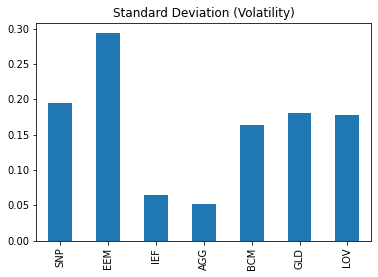

In [12]:
sd = df.std()*np.sqrt(365.25)
sd.plot(kind='bar')
plt.title('Standard Deviation (Volatility)');

> __volatility__  
> - Fixed income (i.e. IEF, AGG ) have the lowest. Although interesting that investment grade bonds have lower vol than EEM however the dividends are distributed
> - Commodities (BCM, LOV) have twice as much 
> - Equity has 3 times as much as fixed income 

### Covariance

In [13]:
# create the covariance matrix. 
# this will be used later in portfolio construction
cov_matrix = df.cov()
cov_matrix

,SNP,EEM,IEF,AGG,BCM,GLD,LOV
SNP,1.518060e-04,1.936971e-04,-2.051694e-05,-3.351367e-06,4.335085e-05,2.840239e-06,4.312711e-07
EEM,1.936971e-04,3.443515e-04,-2.610078e-05,-3.623668e-06,7.875013e-05,1.826941e-05,7.060873e-07
IEF,-2.051694e-05,-2.610078e-05,1.635156e-05,8.439113e-06,-7.774547e-06,3.597723e-06,7.444438e-07
AGG,-3.351367e-06,-3.623668e-06,8.439113e-06,1.087902e-05,1.127561e-07,2.412293e-06,1.109561e-06
BCM,4.335085e-05,7.875013e-05,-7.774547e-06,1.127561e-07,1.081237e-04,3.764651e-05,1.574205e-07
GLD,2.840239e-06,1.826941e-05,3.597723e-06,2.412293e-06,3.764651e-05,1.297434e-04,-9.957715e-08
LOV,4.312711e-07,7.060873e-07,7.444438e-07,1.109561e-06,1.574205e-07,-9.957715e-08,1.265826e-04


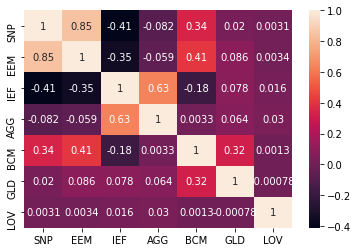

In [14]:
sns.heatmap(df.corr(),annot=True);

> __Correlation__ 
>- Equities (SNP, EEM) have a high correlation
>- Equities (SNP, EEM) have a slight negative correlation to the risk-free return (IEF) (? due to substitution effect?)
>- Fixed Income (IEF, AGG) have a correlation
>- Fixed Income (IEF, AGG) have no to negative correclation with commodities
>- Commodities and gold have a small correlation
>- long vol is least correlated to all portfolios

### Expected Return

SNP    0.099373
EEM    0.071725
IEF    0.045498
AGG    0.039244
BCM   -0.026379
GLD    0.082236
LOV    0.039436
dtype: float64

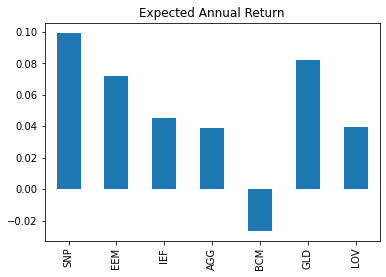

In [15]:
# get average daily return times 365.25 in the year that is extracted from dataset
e_r = df.mean()*365.25

# plot exp return
e_r.plot(kind='bar')
plt.title('Expected Annual Return');

e_r

> __Returns__
> - SNP highest, Commodities lowest.
> - risk-free rate(IEF) is still higher than investment grade bonds
> - long-vol still outperforms commodities
> - although EEM has the highest vol it doesnt have the highest returns which should not be expected because higher volatility or risk is associated with more returns

### Positive and Negative months

In [16]:
for col in df.columns:
    new_col = col + '_sign'
    df[new_col] = np.sign(df[col])

In [22]:
signs = []

for col in df.columns:
    if '_sign' in col:
        signs.append(df[col].value_counts(normalize=True))
        
df_signs = pd.concat(signs,axis=1)

In [23]:
df_signs

,SNP_sign,EEM_sign,IEF_sign,AGG_sign,BCM_sign,GLD_sign,LOV_sign
-1.0,0.443891,0.462159,0.466429,0.448873,0.485172,0.459786,0.022776
0.0,0.000712,0.007355,0.009727,0.015658,0.005931,0.033215,0.952313
1.0,0.555397,0.530486,0.523843,0.535469,0.508897,0.506999,0.024911


# MPT Portfolio construction

For Modern Portfolio Theory there are a few assumptions about investor's objective:
1. maximise returns
2. minimise risk / volatility / standard deviation

In order to make an optimal portfolio is the maximum return for a given level of risk. The following steps is used to determine the optimal portfolio given our constrained assets above.

1. initiate no. of assets and portfolios to simulate. 
2. for each random portfolio (created with random weights)
3. save the return - using weighted average to determine
4. save the volatility - using covariance matrix multiplied by associated weights. 

In [ ]:
"""
p_ret = []
p_weights = []
p_vol = []

# set no. of assets and portfolios to simulate
num_assets = len(df_px.columns)
num_portfolios = 10_000_000

# for each random portfolio, find the return and volatility
for portfolio in range(num_portfolios):
    # create random weights
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    
    returns = np.dot(weights,e_r)
    p_ret.append(returns)
    
    var = cov_matrix.mul(weights,axis=0).mul(weights,axis=1).sum().sum()
    ann_sd = np.sqrt(var*365.25)
    p_vol.append(ann_sd)
    
data = {'returns': p_ret, 'volatility': p_vol}

for counter, symbol in enumerate(df_px.columns.tolist()):
    data[symbol + '_weight'] = [w[counter] for w in p_weights]
    
portfolios = pd.DataFrame(data)

portfolios.to_csv('./data/portfolios.csv',index=False)
"""

In [8]:
portfolios = pd.read_csv('./data/portfolios.csv')

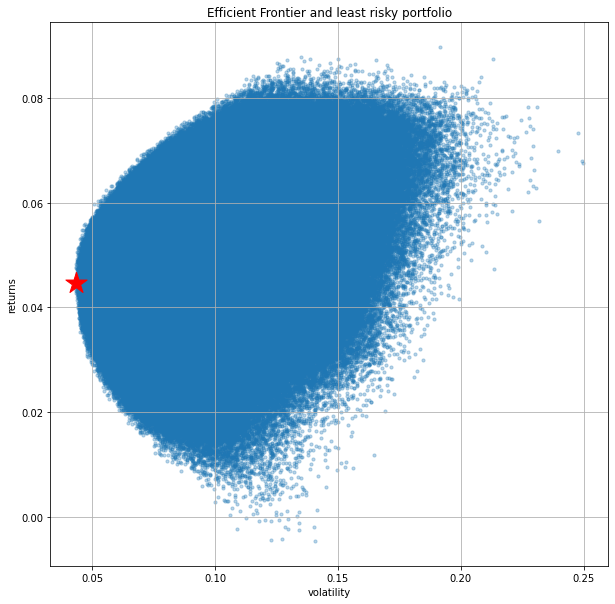

In [13]:
# portfolios with lowest volatility
min_var_port = portfolios.loc[portfolios['volatility'].idxmin()]

portfolios.plot.scatter(x='volatility',y='returns',grid=True,\
                        marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=min_var_port[1],y=min_var_port[0],\
            color='r', marker='*', s=500)
plt.title('Efficient Frontier and least risky portfolio');

The red star indicates the random portfolio with the least volatility

In [26]:
portfolios.head(3).T

,0,1,2
returns,0.048579,0.055351,0.047478
volatility,0.093695,0.059068,0.083025
SNP_weight,0.215940,0.163896,0.111519
EEM_weight,0.106368,0.019979,0.137280
IEF_weight,0.192621,0.220399,0.165638
AGG_weight,0.032216,0.251495,0.146452
BCM_weight,0.198192,0.043448,0.138795
GLD_weight,0.108597,0.163975,0.118782
LOV_weight,0.146066,0.136807,0.181534
sharpe,0.509941,0.923536,0.562218


In [28]:
min_var_port[:2]

returns       0.044617
volatility    0.043290
Name: 1027153, dtype: float64


### Optimal Risky Portfolio
$$Sharpe Ratio = \frac{E(R_i)-rf}{\sigma_i}$$
Sharpe Ratio is the ratio of return to volatility. The larger the ratio, the more return per unit vol.

rf is the risk free rate of 0.08% since the time horizon for each portfolio is 1 month before the portfolio is re-adjusted

In [14]:
rf = np.log(1+.0008)

In [15]:
portfolios['sharpe'] = (portfolios['returns']-rf)/portfolios['volatility']

In [16]:
sharpe_max = portfolios.loc[portfolios['sharpe'].idxmax()]
sharpe_max

returns       0.055728
volatility    0.046624
SNP_weight    0.159667
EEM_weight    0.009140
IEF_weight    0.603856
AGG_weight    0.122059
BCM_weight    0.001825
GLD_weight    0.067994
LOV_weight    0.035458
sharpe        1.178106
Name: 8611687, dtype: float64

The Sharpe optimised portfolio favours the more safe returns.

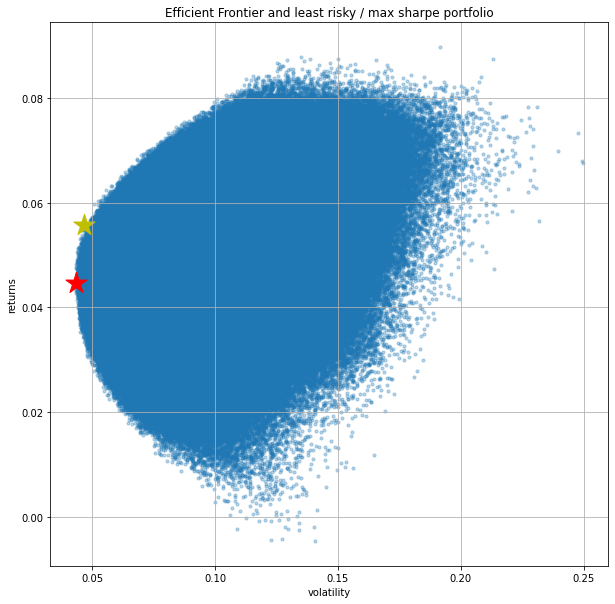

In [17]:
# plot the 
portfolios.plot.scatter(x='volatility',y='returns',grid=True,\
                        marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=min_var_port[1],y=min_var_port[0],\
            color='r', marker='*', s=500);
plt.scatter(x=sharpe_max[1],y=sharpe_max[0],\
            color='y', marker='*', s=500);
plt.title('Efficient Frontier and least risky / max sharpe portfolio');

### Capital Allocation Line
$$E(R_P) = rf + \frac{E(R_i)-rf}{\sigma_i}\sigma_p$$
This line implies all the possible allocations of portfolio. i.e. different combinations of the sharpe optimised portfolio and a risk-free asset (e.g. T-bill) (from risk free to most risk).

There is a linear relationship in returns, because th portfolio only has 2 components and as the risky portfolio weight decreases the returns decrease monotonously. linear relationship in sd due to the risk-free having 0 vol so the decrease in volatility from the optimal portfolio to risk free is monotonous.

### Utility Function
$$U = E(R)-0.5A\sigma^2$$
This function is from a economic model. Higher return leads to higher utility.
A is the coefficient of risk aversion. If A is small then the are less risk averse. We assume 25 < A < 35.

Expected return is the level of utility and is discounted by level of risk aversion.

Here we will use 3.5 as a conservative level

### Final optimised portfolio
To come up with the final optimised portfolio below, we find the intersection of the Capital allocation line and Utility function

Assumptions
- investors always want to reduce risk
- investors want the greatest return for risk

In [18]:
cal_x = []
cal_y = []
utility = []
a = 35
max_returns = portfolios.returns.max()

for er in np.linspace(rf, max_returns, 1000):
    sd = (er - rf)/((sharpe_max[0]-rf)/sharpe_max[1])
    u = er - .5*a*(sd**2)
    cal_x.append(sd)
    cal_y.append(er)
    utility.append(u)
    
data2 = {'utility':utility, 'cal_y':cal_y, 'cal_x':cal_x}
cal = pd.DataFrame(data2)
cal.head()

,utility,cal_y,cal_x
0,0.000800,0.000800,0.000000
1,0.000889,0.000889,0.000076
2,0.000977,0.000978,0.000151
3,0.001066,0.001067,0.000227
4,0.001154,0.001156,0.000302


In [19]:
investors_port = cal.iloc[cal['utility'].idxmax()]
investors_port

utility    0.020627
cal_y      0.040493
cal_x      0.033693
Name: 446, dtype: float64

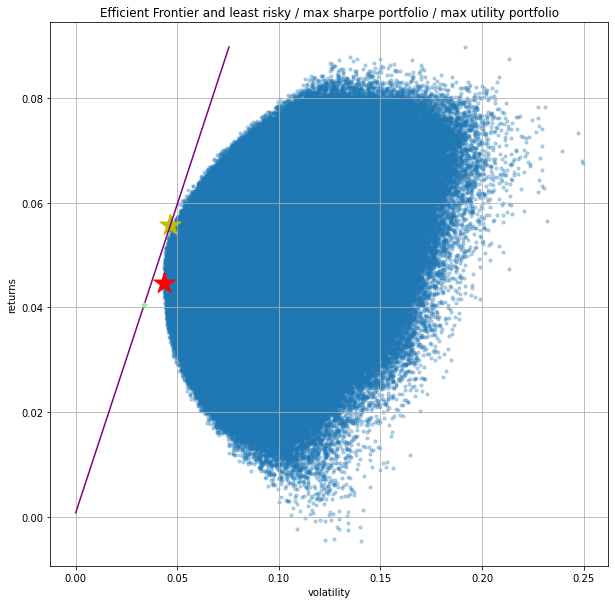

In [31]:
portfolios.plot.scatter(x='volatility',y='returns',grid=True,\
                        marker='o', s=10, alpha=0.3,figsize=[10,10])
plt.scatter(x=min_var_port[1],y=min_var_port[0],\
            color='r', marker='*', s=500)
plt.scatter(x=sharpe_max[1],y=sharpe_max[0],\
            color='y', marker='*', s=500)
plt.plot(cal_x, cal_y, color='purple')
plt.plot(investors_port[2], investors_port[1], '*', color='lightgreen')
plt.title('Efficient Frontier and least risky / max sharpe portfolio / max utility portfolio');

# Utility adjusted Portfolio

The point on the CAL is a weighted combination of complete sharpe optimised or rf (cash) portfolios. The final portfolio mix is found by the ratio of return vs the sharpe optimised 

In [46]:
# find weight of sharpe optimised portfolio
pct_risk = investors_port[2]/sharpe_max[1]

# find final returns, vol, weights of 
# sharpe optimised portfolio components
risk = sharpe_max[2:]*pct_risk

# find final returns, vol, weights of rf
risk_free = pd.Series([(1-pct_risk)], index=['Cash'])

port_fin = pd.concat([investors_port,risk,risk_free], axis=0).rename({'cal_y':'returns', 'cal_x':'volatility'})
port_fin

utility       0.020627
returns       0.040493
volatility    0.033693
SNP_weight    0.115383
EEM_weight    0.006605
IEF_weight    0.436373
AGG_weight    0.088206
BCM_weight    0.001319
GLD_weight    0.049135
LOV_weight    0.025624
sharpe        0.851351
Cash          0.277356
dtype: float64

## Validating greatest utility, return, volatility
There is alternative to using the Capital Allocation Line. Here, the utility for each portfolio can be calculated, solving for the maximum utility.

Then then compare the returns of the Capital Allocation Line for the same risk.

On Capital Allocation Line:

| util  | return  | volatility  |
|---|---|---|
| 0.060 |  0.124 |  0.160 | 
| 0.058 |  0.131 |  0.171 | 
		
On Efficient Frontier:

| util  | return  | volatility  |
|---|---|---|
| -0.0172 |  0.114 |0.162|

It can be seen the CAL allocates with higher return with even lower volatility. Also the point on the Efficient Frontier does not maximise return to volatility.

In [22]:
portfolios['utility'] = portfolios['returns'] - .5*a*(portfolios['volatility']**2)

In [23]:
portfolios.loc[portfolios['utility'].idxmax()]

returns       0.055728
volatility    0.046624
SNP_weight    0.159667
EEM_weight    0.009140
IEF_weight    0.603856
AGG_weight    0.122059
BCM_weight    0.001825
GLD_weight    0.067994
LOV_weight    0.035458
sharpe        1.178106
utility       0.017686
Name: 8611687, dtype: float64

In [24]:
cal.utility.describe()

count    1000.000000
mean        0.012014
std         0.008072
min        -0.009962
25%         0.006599
50%         0.014385
75%         0.019061
max         0.020627
Name: utility, dtype: float64